In [17]:
# CNN 계층 구현

import sys, os
sys.path.append(os.pardir)
from collections import OrderedDict
from common.layers import *


class SimpleConvNet:
    def __init__(self, input_dim=(1, 28, 28), conv_param={ # input_dim : 입력 데이터(채널 수, 높이, 너비)의 차원
        'filter_num':30, # 필터 수
        'filter_size':5, # 필터 크기
        'pad':0,
        'stride':1},
                 hidden_size = 100, # 은닉층(완전연결)의 뉴런 수
                 output_size = 10, # 출력(완전연결)의 뉴런 수
                 weight_init_std=0.01): # 초기화 때의 가중치표준편차
        
        # 1. 합성곱 계층의 하이퍼파라미터를 딕셔너리에서 꺼내기
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = ((input_size - filter_size + 2*filter_pad) / filter_stride) +1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))
        
        # 2. 가중치 매개변수 초기화
        self.params = {}
        # 합성곱Conv 계층
        self.params['W1'] = weight_init_std * np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        # 완전연결계층
        self.params['W2'] = weight_init_std * np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        # 완전연결계층
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)
        
        # 3. CNN 구성 계층 생성
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'], conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss() # 최종계층은 별도 변수에 저장
        
        
    # 추론
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x

    # 손실 함수 값 계산 - 추론을 호출한 뒤 마지막 출력 층 계산까지 모두 마침 - 즉 forward를 첫 계층에서 마지막 계층까지 모두 처리
    def loss(self, x, t):
        y = self.predict(x)
        return self.last_layer.forward(y, t)
    
    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]


    def gradient(self, x, t):
        # 순전파
        self.loss(x, t)

        # 역전파
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
    
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]

In [ ]:
# MNIST 데이터셋으로 SimpConvNet 학습하기

import sys, os
sys.path.append(os.pardir)
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

network.save_params("params.pkl")
print("Saved Network Parameters!")

markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

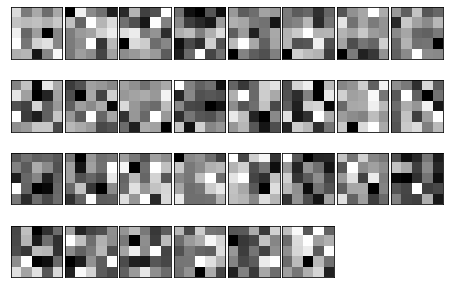

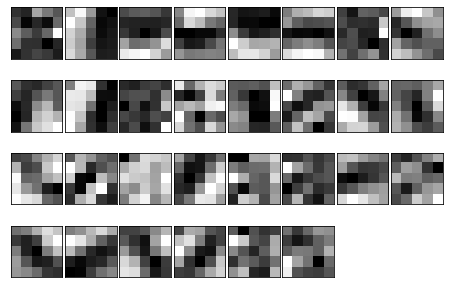

In [4]:
# CNN 시각화하기

import numpy as np
import matplotlib.pyplot as plt
from simple_convnet import SimpleConvNet

def filter_show(filters, nx=8, margin=3, scale=10):
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()


network = SimpleConvNet()
filter_show(network.params['W1'])

network.load_params("params.pkl")
filter_show(network.params['W1'])


In [5]:
# 위의 사진을 보면, 1번째 층 학습 전에는 필터가 무작위 초기화상태여서 흑백 정도에 규칙성이 없다.
# 그러나 1번째 층 학습을 마친 필터는 규칙성 있는 이미지(덩어리-블롭,blob-가 진 필터)가 되었다.

# 이렇게 학습을 마친 필터는 에지(색상이 바뀐 경계선)과 블롭(국소적으로 덩어리진 영역)을 보고있다.
# 이처럼 합성곱 계층의 필터는 에지나 블롭 등의 원시적인 정보를 추출할 수 있다.